## Subtask 2 (Headline)

In [1]:
#importing the required libraries
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from __future__ import print_function

import os
import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
import json
from pprint import pprint
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from numpy.random import RandomState
prng = RandomState(1234567890)
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors

Using TensorFlow backend.


## Importing the datasets

In [46]:
with open('C:\\Users\mites\Documents\Cognitive\Midterm\Rawdata\ssix-project-semeval-2017-task-5-subtask-2-2fb645e839b7\Headline_Trainingdata.json') as data_file:    
    data = json.load(data_file)

pprint(data[:5])

[{'company': 'Morrisons',
  'id': 2,
  'sentiment': 0.43,
  'title': 'Morrisons book second consecutive quarter of sales growth'},
 {'company': 'IMI',
  'id': 3,
  'sentiment': -0.344,
  'title': 'IMI posts drop in first-quarter organic revenue; warns on full '
           'year'},
 {'company': 'Glencore',
  'id': 4,
  'sentiment': 0.34,
  'title': 'Glencore to refinance its short-term debt early, shares rise'},
 {'company': 'Ryanair',
  'id': 5,
  'sentiment': 0.259,
  'title': 'EasyJet attracts more passengers in June but still lags Ryanair'},
 {'company': 'Barclays',
  'id': 6,
  'sentiment': -0.231,
  'title': "Barclays 'bad bank' chief to step down"}]


In [4]:
with open('C:\\Users\mites\Documents\Cognitive\Midterm\Rawdata\ssix-project-semeval-2017-task-5-subtask-2-2fb645e839b7\Headlines_Testdata.json',encoding="utf8") as data_files:    
    datatest = json.load(data_files)

pprint(datatest[:5])

[{'company': 'Ashtead',
  'id': 1144,
  'title': 'Ashtead to buy back shares, full-year profit beats estimates'},
 {'company': 'Shell',
  'id': 1145,
  'title': "EU regulators clear Shell's takeover of BG Group"},
 {'company': 'Prudential',
  'id': 1146,
  'title': "UK's FTSE has worst day so far in 2015 as BG and Prudential fall"},
 {'company': 'GlaxoSmithKline',
  'id': 1147,
  'title': 'GlaxoSmithKline acquires HIV assets'},
 {'company': 'Barclays',
  'id': 1148,
  'title': 'Barclays faces another heavy forex fine'}]


In [47]:
idss = [x["id"] for x in data]
companys = [x["company"] for x in data]
titles = [x["title"] for x in data]
score = [x["sentiment"] for x in data]

## Encoding the sentiment scores

In [6]:
result= list(map(float, score))
sentscr=[]
for item in result:
   
    if item>=-1 and item<=-0.3:
        sentscr.append(-1)
    elif item>-0.3 and item<=0.3:
        sentscr.append(0)
    else: 
        sentscr.append(1)
        
sentscr[:5]

[1, -1, 1, 0, 0]

In [7]:
vv = sentscr[:1142]

In [8]:
vvv = np.array(vv).reshape(1,-1)

## Putting the data into dataframe

In [9]:
df = pd.DataFrame(
    {'id':ids,
     'company': company,
     'sentimentscore': sentscr,
    })
df[:5]

,company,id,sentimentscore
0,Morrisons,2,1
1,IMI,3,-1
2,Glencore,4,1
3,Ryanair,5,0
4,Barclays,6,0


In [10]:
df1 = pd.DataFrame(
    {'title':title
    })
df1[:5]

,title
0,Morrisons book second consecutive quarter of s...
1,IMI posts drop in first-quarter organic revenu...
2,Glencore to refinance its short-term debt earl...
3,EasyJet attracts more passengers in June but s...
4,Barclays 'bad bank' chief to step down


In [11]:
a = df1.title.astype(str).str.replace('\[|\]|\'', '')
a[:5]

0    Morrisons book second consecutive quarter of s...
1    IMI posts drop in first-quarter organic revenu...
2    Glencore to refinance its short-term debt earl...
3    EasyJet attracts more passengers in June but s...
4                 Barclays bad bank chief to step down
Name: title, dtype: object

In [12]:
df2=a.to_frame()
df2[:5]

,title
0,Morrisons book second consecutive quarter of s...
1,IMI posts drop in first-quarter organic revenu...
2,Glencore to refinance its short-term debt earl...
3,EasyJet attracts more passengers in June but s...
4,Barclays bad bank chief to step down


In [13]:
dataframe = df.join(df2)
dataframe[:10]

,company,id,sentimentscore,title
0,Morrisons,2,1,Morrisons book second consecutive quarter of s...
1,IMI,3,-1,IMI posts drop in first-quarter organic revenu...
2,Glencore,4,1,Glencore to refinance its short-term debt earl...
3,Ryanair,5,0,EasyJet attracts more passengers in June but s...
4,Barclays,6,0,Barclays bad bank chief to step down
5,BP,7,0,Bilfinger Industrial Services win Ã‚Â£100m BP ...
6,Bilfinger Industrial Services,8,1,Bilfinger Industrial Services win Ã‚Â£100m BP ...
7,Barclays,9,-1,Barclays share price subdued as bank faces fre...
8,Centrica PLC,10,0,Centrica prepared for takeover approach - chai...
9,Glencore,11,0,Jim Armitage: Spare no tears as Glencores boss...


In [14]:
ids = [x["id"] for x in datatest]
company = [x["company"] for x in datatest]
title = [x["title"] for x in datatest]

In [15]:
dft = pd.DataFrame(
    {'id':ids,
     'company': company,
    })
dft[:10]

,company,id
0,Ashtead,1144
1,Shell,1145
2,Prudential,1146
3,GlaxoSmithKline,1147
4,Barclays,1148
5,Diageo,1149
6,Borealis Infrastructure,1150
7,Burberry Group plc,1151
8,Deutsche Boerse,1152
9,Tesco PLC,1153


In [16]:
dft1 = pd.DataFrame(
    {'title':title
    })
dft1[:10]

,title
0,"Ashtead to buy back shares, full-year profit b..."
1,EU regulators clear Shell's takeover of BG Group
2,UK's FTSE has worst day so far in 2015 as BG a...
3,GlaxoSmithKline acquires HIV assets
4,Barclays faces another heavy forex fine
5,Diageo Shares Surge on Report of Possible Take...
6,Borealis Infrastructure putting together new S...
7,FTSE 100 falls as China devaluation hits Burbe...
8,London Stock Exchange â€“ Deutsche Boerse merg...
9,Tesco Abandons Video-Streaming Ambitions in Bl...


In [17]:
b = dft1.title.astype(str).str.replace('\[|\]|\'', '')
b[:10]

0    Ashtead to buy back shares, full-year profit b...
1      EU regulators clear Shells takeover of BG Group
2    UKs FTSE has worst day so far in 2015 as BG an...
3                  GlaxoSmithKline acquires HIV assets
4              Barclays faces another heavy forex fine
5    Diageo Shares Surge on Report of Possible Take...
6    Borealis Infrastructure putting together new S...
7    FTSE 100 falls as China devaluation hits Burbe...
8    London Stock Exchange â€“ Deutsche Boerse merg...
9    Tesco Abandons Video-Streaming Ambitions in Bl...
Name: title, dtype: object

In [18]:
dft2=b.to_frame()
dft2[:10]

,title
0,"Ashtead to buy back shares, full-year profit b..."
1,EU regulators clear Shells takeover of BG Group
2,UKs FTSE has worst day so far in 2015 as BG an...
3,GlaxoSmithKline acquires HIV assets
4,Barclays faces another heavy forex fine
5,Diageo Shares Surge on Report of Possible Take...
6,Borealis Infrastructure putting together new S...
7,FTSE 100 falls as China devaluation hits Burbe...
8,London Stock Exchange â€“ Deutsche Boerse merg...
9,Tesco Abandons Video-Streaming Ambitions in Bl...


In [19]:
testdataframe = dft.join(dft2)
testdataframe[:10]

,company,id,title
0,Ashtead,1144,"Ashtead to buy back shares, full-year profit b..."
1,Shell,1145,EU regulators clear Shells takeover of BG Group
2,Prudential,1146,UKs FTSE has worst day so far in 2015 as BG an...
3,GlaxoSmithKline,1147,GlaxoSmithKline acquires HIV assets
4,Barclays,1148,Barclays faces another heavy forex fine
5,Diageo,1149,Diageo Shares Surge on Report of Possible Take...
6,Borealis Infrastructure,1150,Borealis Infrastructure putting together new S...
7,Burberry Group plc,1151,FTSE 100 falls as China devaluation hits Burbe...
8,Deutsche Boerse,1152,London Stock Exchange â€“ Deutsche Boerse merg...
9,Tesco PLC,1153,Tesco Abandons Video-Streaming Ambitions in Bl...


In [20]:
testdataframe = testdataframe[['id','company','title']]
testdataframe[:5]

,id,company,title
0,1144,Ashtead,"Ashtead to buy back shares, full-year profit b..."
1,1145,Shell,EU regulators clear Shells takeover of BG Group
2,1146,Prudential,UKs FTSE has worst day so far in 2015 as BG an...
3,1147,GlaxoSmithKline,GlaxoSmithKline acquires HIV assets
4,1148,Barclays,Barclays faces another heavy forex fine


## Using Twitter pre-trained word vector

In [21]:
BASE_DIR = 'C:\\Users\mites\Documents\Cognitive\Midterm'
GLOVE_DIR = BASE_DIR + '\GoogleNews-vectors-negative300'

MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000

# Consider changing the 200 to 25
EMBEDDING_DIM = 300
GLOVE_FILE = 'C:\\Users\mites\Documents\Cognitive\Midterm\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin'

In [22]:
print('Indexing word vectors.')

embeddings_index = {} # word -> coefs
# We'll use the 100-dimensional version
#f = open(os.path.join(GLOVE_DIR, GLOVE_FILE), encoding="utf8")
word2vec = KeyedVectors.load_word2vec_format(GLOVE_FILE, binary=True)

Indexing word vectors.


In [23]:
#Selecting the columns except the last one i.e sentiment score
X = dataframe.iloc[:,3].values
Xt = testdataframe.iloc[:,2].values

## Tokenizing the words

In [26]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
data = pad_sequences(sequences, maxlen=300)

In [25]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(Xt)
sequences = tokenizer.texts_to_sequences(Xt)
testdata = pad_sequences(sequences, maxlen=300)

In [27]:
print(tokenizer.word_index)

{'to': 1, 'for': 2, 'in': 3, 'as': 4, 'of': 5, 'and': 6, 'barclays': 7, 'with': 8, 'on': 9, 'tesco': 10, 'group': 11, 'plc': 12, 'up': 13, 'update': 14, 'price': 15, 'by': 16, 'deal': 17, 'share': 18, 'ftse': 19, 'profit': 20, 'from': 21, 'astrazeneca': 22, 'after': 23, 'bp': 24, 'billion': 25, 'new': 26, 'shell': 27, 'says': 28, 'oil': 29, '1': 30, 'ceo': 31, 'stake': 32, 'shares': 33, 'bank': 34, 'at': 35, 'uk': 36, 'a': 37, 'standard': 38, 'buy': 39, 'drug': 40, 'sales': 41, 'glencore': 42, '2': 43, 'royal': 44, 'rbs': 45, 'over': 46, 'us': 47, 'the': 48, 'sells': 49, 'ab': 50, 'morrisons': 51, 'inbev': 52, 'takeover': 53, 'hit': 54, 'sale': 55, 'london': 56, 'lloyds': 57, 'bg': 58, 'year': 59, 'sell': 60, 'pay': 61, 'bid': 62, '3': 63, 'sabmiller': 64, 'aviva': 65, 'chartered': 66, 'easyjet': 67, 'more': 68, 'life': 69, 'cut': 70, 'shire': 71, '5': 72, 'berkshire': 73, 'is': 74, 'business': 75, 'britains': 76, '100': 77, 'first': 78, 'chief': 79, 'jobs': 80, 'unit': 81, 'hsbc': 82,

In [28]:
word2index = tokenizer.word_index
len(word2index)

2731

In [29]:
Y = np.array(dataframe.iloc[:,2].values)
Y

array([ 1, -1,  1, ..., -1,  1, -1], dtype=int64)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(data,Y, test_size=0.5)

In [31]:
seed = 123
np.random.seed(seed)
np.random.shuffle(x_train)
np.random.seed(seed) # same shuffle for labels!
np.random.shuffle(y_train)

np.random.seed(seed * 2)
np.random.shuffle(x_test)
np.random.seed(seed * 2)
np.random.shuffle(y_test)

## Padding sequence to convert the train data into two dimension

In [32]:
print('Pad sequences')
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (571, 300)
x_test shape: (571, 300)


In [33]:
x_train[x_train >= MAX_NB_WORDS] = MAX_NB_WORDS-1
x_test[x_test >= MAX_NB_WORDS] = MAX_NB_WORDS-1

In [34]:
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word2index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word2index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix
Null word embeddings: 497


## Training a MLP model

In [35]:
# train a regular MLP
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(25, activation='linear')(x)
x = Dropout(0.5)(x)
x = Dense(25, activation='linear')(x)
preds = Dense(1, activation='tanh')(x)

model_mlp = Model(sequence_input, preds)
model_mlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [36]:
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          819600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2250025   
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total para

In [39]:
print('Training model.')
history = model_mlp.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=200, batch_size=32)

Training model.
Train on 571 samples, validate on 571 samples
Epoch 1/200
571/571 [==============================] - ETA: 4s - loss: -2.0148 - acc: 0.46 - ETA: 1s - loss: -2.7703 - acc: 0.43 - ETA: 0s - loss: -2.5995 - acc: 0.42 - ETA: 0s - loss: -3.0761 - acc: 0.47 - ETA: 0s - loss: -3.3145 - acc: 0.49 - ETA: 0s - loss: -3.4526 - acc: 0.49 - ETA: 0s - loss: -3.5840 - acc: 0.49 - 0s - loss: -3.7251 - acc: 0.5026 - val_loss: 0.5981 - val_acc: 0.3012
Epoch 2/200
571/571 [==============================] - ETA: 0s - loss: -3.5258 - acc: 0.43 - ETA: 0s - loss: -3.5257 - acc: 0.50 - ETA: 0s - loss: -3.2739 - acc: 0.48 - ETA: 0s - loss: -3.5258 - acc: 0.50 - ETA: 0s - loss: -3.7776 - acc: 0.49 - ETA: 0s - loss: -3.5929 - acc: 0.49 - ETA: 0s - loss: -3.7035 - acc: 0.49 - 0s - loss: -3.7260 - acc: 0.5009 - val_loss: 0.6635 - val_acc: 0.3082
Epoch 3/200
571/571 [==============================] - ETA: 0s - loss: -2.0148 - acc: 0.46 - ETA: 0s - loss: -3.1481 - acc: 0.52 - ETA: 0s - loss: -3.0941 -

Epoch 23/200
571/571 [==============================] - ETA: 0s - loss: -3.5258 - acc: 0.50 - ETA: 0s - loss: -4.2788 - acc: 0.50 - ETA: 0s - loss: -3.9439 - acc: 0.48 - ETA: 0s - loss: -3.7486 - acc: 0.48 - ETA: 0s - loss: -3.6916 - acc: 0.48 - ETA: 0s - loss: -3.8264 - acc: 0.50 - ETA: 0s - loss: -3.7614 - acc: 0.50 - 0s - loss: -3.7529 - acc: 0.5061 - val_loss: 0.7638 - val_acc: 0.3187
Epoch 24/200
571/571 [==============================] - ETA: 0s - loss: -2.5185 - acc: 0.50 - ETA: 0s - loss: -3.2740 - acc: 0.51 - ETA: 0s - loss: -3.3819 - acc: 0.49 - ETA: 0s - loss: -3.7497 - acc: 0.48 - ETA: 0s - loss: -3.6098 - acc: 0.48 - ETA: 0s - loss: -3.7057 - acc: 0.50 - ETA: 0s - loss: -3.8517 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5009 - val_loss: 0.8833 - val_acc: 0.3205
Epoch 25/200
571/571 [==============================] - ETA: 0s - loss: -2.5185 - acc: 0.40 - ETA: 0s - loss: -3.5258 - acc: 0.46 - ETA: 0s - loss: -4.0295 - acc: 0.48 - ETA: 0s - loss: -3.8053 - acc: 0.51 - ETA: 0s 

571/571 [==============================] - ETA: 0s - loss: -4.5332 - acc: 0.46 - ETA: 0s - loss: -4.4073 - acc: 0.53 - ETA: 0s - loss: -4.2441 - acc: 0.53 - ETA: 0s - loss: -4.4819 - acc: 0.52 - ETA: 0s - loss: -4.1451 - acc: 0.51 - ETA: 0s - loss: -3.9975 - acc: 0.50 - 0s - loss: -3.7538 - acc: 0.5026 - val_loss: 0.9507 - val_acc: 0.3047
Epoch 46/200
571/571 [==============================] - ETA: 0s - loss: -2.5184 - acc: 0.46 - ETA: 0s - loss: -3.7772 - acc: 0.46 - ETA: 0s - loss: -3.6695 - acc: 0.49 - ETA: 0s - loss: -3.6365 - acc: 0.50 - ETA: 0s - loss: -3.3990 - acc: 0.49 - ETA: 0s - loss: -3.6594 - acc: 0.50 - ETA: 0s - loss: -3.6733 - acc: 0.50 - 0s - loss: -3.7537 - acc: 0.5009 - val_loss: 0.9468 - val_acc: 0.3047
Epoch 47/200
571/571 [==============================] - ETA: 0s - loss: -3.5258 - acc: 0.59 - ETA: 0s - loss: -3.5187 - acc: 0.51 - ETA: 0s - loss: -3.5937 - acc: 0.50 - ETA: 0s - loss: -3.6741 - acc: 0.49 - ETA: 0s - loss: -4.1048 - acc: 0.50 - ETA: 0s - loss: -3.77

571/571 [==============================] - ETA: 0s - loss: -3.0221 - acc: 0.65 - ETA: 0s - loss: -2.9993 - acc: 0.46 - ETA: 0s - loss: -3.8006 - acc: 0.50 - ETA: 0s - loss: -4.0204 - acc: 0.51 - ETA: 0s - loss: -3.9062 - acc: 0.50 - ETA: 0s - loss: -3.8034 - acc: 0.49 - 0s - loss: -3.7492 - acc: 0.5026 - val_loss: 0.9811 - val_acc: 0.3117
Epoch 68/200
571/571 [==============================] - ETA: 0s - loss: -4.5332 - acc: 0.62 - ETA: 0s - loss: -4.0295 - acc: 0.51 - ETA: 0s - loss: -4.1135 - acc: 0.53 - ETA: 0s - loss: -3.5258 - acc: 0.49 - ETA: 0s - loss: -3.6266 - acc: 0.50 - ETA: 0s - loss: -3.9908 - acc: 0.50 - ETA: 0s - loss: -3.8092 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5009 - val_loss: 1.0004 - val_acc: 0.3065
Epoch 69/200
571/571 [==============================] - ETA: 0s - loss: -4.0295 - acc: 0.62 - ETA: 0s - loss: -4.0295 - acc: 0.54 - ETA: 0s - loss: -4.6052 - acc: 0.57 - ETA: 0s - loss: -4.1806 - acc: 0.52 - ETA: 0s - loss: -4.0702 - acc: 0.53 - ETA: 0s - loss: -3.89

571/571 [==============================] - ETA: 0s - loss: -2.5185 - acc: 0.34 - ETA: 0s - loss: -3.5258 - acc: 0.46 - ETA: 0s - loss: -3.5978 - acc: 0.46 - ETA: 0s - loss: -3.8280 - acc: 0.48 - ETA: 0s - loss: -3.6808 - acc: 0.49 - ETA: 0s - loss: -3.5888 - acc: 0.49 - 0s - loss: -3.7543 - acc: 0.5044 - val_loss: 0.9188 - val_acc: 0.3047
Epoch 90/200
571/571 [==============================] - ETA: 0s - loss: -4.0295 - acc: 0.43 - ETA: 0s - loss: -4.4073 - acc: 0.51 - ETA: 0s - loss: -4.2454 - acc: 0.53 - ETA: 0s - loss: -3.9792 - acc: 0.50 - ETA: 0s - loss: -3.9875 - acc: 0.51 - ETA: 0s - loss: -4.0295 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 0.9367 - val_acc: 0.3065
Epoch 91/200
571/571 [==============================] - ETA: 0s - loss: -4.5332 - acc: 0.56 - ETA: 0s - loss: -3.1481 - acc: 0.50 - ETA: 0s - loss: -2.8782 - acc: 0.49 - ETA: 0s - loss: -3.3244 - acc: 0.50 - ETA: 0s - loss: -3.6518 - acc: 0.51 - ETA: 0s - loss: -3.7945 - acc: 0.51 - 0s - loss: -3.7543 - 

571/571 [==============================] - ETA: 0s - loss: -3.0221 - acc: 0.31 - ETA: 0s - loss: -3.7777 - acc: 0.48 - ETA: 0s - loss: -3.7417 - acc: 0.48 - ETA: 0s - loss: -3.9792 - acc: 0.50 - ETA: 0s - loss: -3.7583 - acc: 0.50 - ETA: 0s - loss: -3.9351 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 1.0616 - val_acc: 0.2995
Epoch 112/200
571/571 [==============================] - ETA: 0s - loss: -6.0443 - acc: 0.56 - ETA: 0s - loss: -4.4073 - acc: 0.50 - ETA: 0s - loss: -4.2814 - acc: 0.50 - ETA: 0s - loss: -3.4699 - acc: 0.45 - ETA: 0s - loss: -3.7357 - acc: 0.48 - ETA: 0s - loss: -3.7609 - acc: 0.49 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 1.0727 - val_acc: 0.2995
Epoch 113/200
571/571 [==============================] - ETA: 0s - loss: -5.0369 - acc: 0.46 - ETA: 0s - loss: -4.1554 - acc: 0.48 - ETA: 0s - loss: -3.1900 - acc: 0.46 - ETA: 0s - loss: -3.5818 - acc: 0.50 - ETA: 0s - loss: -3.6518 - acc: 0.51 - ETA: 0s - loss: -3.5258 - acc: 0.50 - 0s - loss: -3.7543 

571/571 [==============================] - ETA: 0s - loss: -4.5332 - acc: 0.46 - ETA: 0s - loss: -4.1554 - acc: 0.52 - ETA: 0s - loss: -4.0295 - acc: 0.51 - ETA: 0s - loss: -3.6937 - acc: 0.50 - ETA: 0s - loss: -3.3579 - acc: 0.48 - ETA: 0s - loss: -3.6338 - acc: 0.49 - ETA: 0s - loss: -3.8518 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 0.9584 - val_acc: 0.3012
Epoch 134/200
571/571 [==============================] - ETA: 0s - loss: -3.0221 - acc: 0.40 - ETA: 0s - loss: -2.8962 - acc: 0.49 - ETA: 0s - loss: -3.4539 - acc: 0.48 - ETA: 0s - loss: -3.6266 - acc: 0.50 - ETA: 0s - loss: -3.7196 - acc: 0.50 - ETA: 0s - loss: -3.6203 - acc: 0.49 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 1.0660 - val_acc: 0.3030
Epoch 135/200
571/571 [==============================] - ETA: 0s - loss: -5.5406 - acc: 0.53 - ETA: 0s - loss: -4.1554 - acc: 0.53 - ETA: 0s - loss: -4.7491 - acc: 0.56 - ETA: 0s - loss: -4.2814 - acc: 0.55 - ETA: 0s - loss: -4.0295 - acc: 0.52 - ETA: 0s - loss: -3.

571/571 [==============================] - ETA: 0s - loss: -3.5258 - acc: 0.59 - ETA: 0s - loss: -3.5258 - acc: 0.48 - ETA: 0s - loss: -4.1734 - acc: 0.49 - ETA: 0s - loss: -4.0799 - acc: 0.50 - ETA: 0s - loss: -3.7196 - acc: 0.50 - ETA: 0s - loss: -3.9036 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 1.0822 - val_acc: 0.3012
Epoch 156/200
571/571 [==============================] - ETA: 0s - loss: -8.0590 - acc: 0.65 - ETA: 0s - loss: -4.4073 - acc: 0.54 - ETA: 0s - loss: -4.1734 - acc: 0.53 - ETA: 0s - loss: -3.6769 - acc: 0.52 - ETA: 0s - loss: -3.6808 - acc: 0.51 - ETA: 0s - loss: -3.8721 - acc: 0.52 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 1.1904 - val_acc: 0.3082
Epoch 157/200
571/571 [==============================] - ETA: 0s - loss: -6.0443 - acc: 0.65 - ETA: 0s - loss: -4.2814 - acc: 0.54 - ETA: 0s - loss: -3.9576 - acc: 0.51 - ETA: 0s - loss: -3.8784 - acc: 0.50 - ETA: 0s - loss: -3.8745 - acc: 0.50 - ETA: 0s - loss: -3.8721 - acc: 0.50 - 0s - loss: -3.7543 

571/571 [==============================] - ETA: 0s - loss: -2.5185 - acc: 0.43 - ETA: 0s - loss: -4.0295 - acc: 0.53 - ETA: 0s - loss: -3.9576 - acc: 0.53 - ETA: 0s - loss: -4.1806 - acc: 0.51 - ETA: 0s - loss: -4.1458 - acc: 0.51 - ETA: 0s - loss: -3.8406 - acc: 0.49 - 0s - loss: -3.7543 - acc: 0.5026 - val_loss: 1.1796 - val_acc: 0.2925
Epoch 178/200
571/571 [==============================] - ETA: 0s - loss: -5.0369 - acc: 0.62 - ETA: 0s - loss: -3.5258 - acc: 0.47 - ETA: 0s - loss: -3.1661 - acc: 0.46 - ETA: 0s - loss: -3.6266 - acc: 0.48 - ETA: 0s - loss: -3.8745 - acc: 0.50 - ETA: 0s - loss: -3.8406 - acc: 0.50 - 0s - loss: -3.7543 - acc: 0.5009 - val_loss: 1.1682 - val_acc: 0.2977
Epoch 179/200
571/571 [==============================] - ETA: 0s - loss: -3.0221 - acc: 0.46 - ETA: 0s - loss: -3.1900 - acc: 0.53 - ETA: 0s - loss: -3.7273 - acc: 0.52 - ETA: 0s - loss: -3.6194 - acc: 0.50 - ETA: 0s - loss: -3.9144 - acc: 0.51 - ETA: 0s - loss: -4.1258 - acc: 0.52 - ETA: 0s - loss: -3.

571/571 [==============================] - ETA: 0s - loss: -2.5185 - acc: 0.46 - ETA: 0s - loss: -3.9036 - acc: 0.50 - ETA: 0s - loss: -4.0295 - acc: 0.53 - ETA: 0s - loss: -3.8784 - acc: 0.50 - ETA: 0s - loss: -3.7583 - acc: 0.50 - ETA: 0s - loss: -3.5216 - acc: 0.50 - 0s - loss: -3.7787 - acc: 0.5044 - val_loss: 1.1567 - val_acc: 0.3082
Epoch 200/200
571/571 [==============================] - ETA: 0s - loss: -2.0148 - acc: 0.34 - ETA: 0s - loss: -2.8962 - acc: 0.44 - ETA: 0s - loss: -3.5978 - acc: 0.49 - ETA: 0s - loss: -3.9288 - acc: 0.49 - ETA: 0s - loss: -4.0683 - acc: 0.49 - ETA: 0s - loss: -3.8721 - acc: 0.49 - 0s - loss: -3.7825 - acc: 0.5044 - val_loss: 1.1631 - val_acc: 0.3082


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


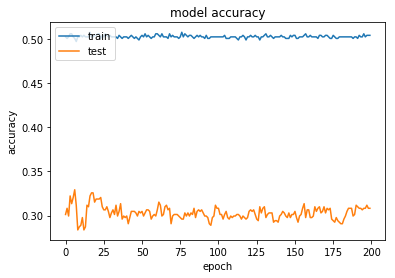

In [40]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

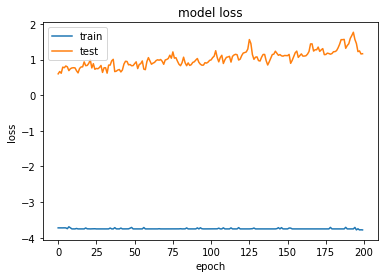

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predicting the sentiment scores for the test data

In [42]:
preds = model_mlp.predict(data, batch_size=32, verbose=1)

1142/1142 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s     


In [43]:
abc = preds.astype(int).flatten().flatten()
zxy = pd.DataFrame({'predictedvalues': abc})

In [44]:
zxy[:5]

,predictedvalues
0,0
1,-1
2,0
3,-1
4,-1


In [50]:
predsubmission = pd.DataFrame({'id':idss,
                               'company': companys,
                               'title':titles,
                               'sentimentscore': sentscr
                               })

In [51]:
predicted = predsubmission.join(zxy)
predicted[:10]

,company,id,sentimentscore,title,predictedvalues
0,Morrisons,2,1,Morrisons book second consecutive quarter of s...,0
1,IMI,3,-1,IMI posts drop in first-quarter organic revenu...,-1
2,Glencore,4,1,Glencore to refinance its short-term debt earl...,0
3,Ryanair,5,0,EasyJet attracts more passengers in June but s...,-1
4,Barclays,6,0,Barclays 'bad bank' chief to step down,-1
5,BP,7,0,Bilfinger Industrial Services win Ã‚Â£100m BP ...,1
6,Bilfinger Industrial Services,8,1,Bilfinger Industrial Services win Ã‚Â£100m BP ...,1
7,Barclays,9,-1,Barclays share price subdued as bank faces fre...,-1
8,Centrica PLC,10,0,Centrica prepared for takeover approach - chai...,0
9,Glencore,11,0,Jim Armitage: Spare no tears as Glencore's bos...,-1


In [52]:
predicted = predicted[['id','company', 'title', 'sentimentscore','predictedvalues']]
predicted[:5]

,id,company,title,sentimentscore,predictedvalues
0,2,Morrisons,Morrisons book second consecutive quarter of s...,1,0
1,3,IMI,IMI posts drop in first-quarter organic revenu...,-1,-1
2,4,Glencore,Glencore to refinance its short-term debt earl...,1,0
3,5,Ryanair,EasyJet attracts more passengers in June but s...,0,-1
4,6,Barclays,Barclays 'bad bank' chief to step down,0,-1


## Writing the predicted scores to CSV file

In [53]:
predicted.to_csv('Task2_test.csv', index=False)

## Building the LSTM model

In [66]:
print('Build model...')
batch_size = 32
maxlen = 80

x_train_short = pad_sequences(x_train, maxlen=maxlen)
x_test_short = pad_sequences(x_train, maxlen=maxlen)

model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, 128))
model_lstm.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='linear'))

# try using different optimizers and different optimizer configs
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
lstmhistory = model_lstm.fit(x_train_short, y_train, batch_size=batch_size, epochs=150,
          validation_data=(x_test_short, y_test))

Build model...
Train...
Train on 571 samples, validate on 571 samples
Epoch 1/150
571/571 [==============================] - ETA: 24s - loss: -1.1056 - acc: 0.437 - ETA: 12s - loss: -0.8891 - acc: 0.468 - ETA: 8s - loss: 0.4146 - acc: 0.4375  - ETA: 6s - loss: 0.0591 - acc: 0.453 - ETA: 4s - loss: 0.1480 - acc: 0.481 - ETA: 4s - loss: 0.2073 - acc: 0.500 - ETA: 3s - loss: 0.2497 - acc: 0.504 - ETA: 2s - loss: 0.0925 - acc: 0.511 - ETA: 2s - loss: 0.0822 - acc: 0.517 - ETA: 1s - loss: 0.5273 - acc: 0.518 - ETA: 1s - loss: 0.3420 - acc: 0.531 - ETA: 1s - loss: 0.5654 - acc: 0.513 - ETA: 1s - loss: 0.9093 - acc: 0.512 - ETA: 0s - loss: 0.7724 - acc: 0.506 - ETA: 0s - loss: 0.6202 - acc: 0.504 - ETA: 0s - loss: 0.7074 - acc: 0.503 - ETA: 0s - loss: 0.7250 - acc: 0.500 - 4s - loss: 0.6907 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 2/150
571/571 [==============================] - ETA: 2s - loss: 2.0148 - acc: 0.625 - ETA: 1s - loss: 0.5037 - acc: 0.593 - ETA: 1s - loss: 0.1679 

571/571 [==============================] - ETA: 1s - loss: -1.0074 - acc: 0.62 - ETA: 1s - loss: -1.2592 - acc: 0.57 - ETA: 1s - loss: -0.5037 - acc: 0.53 - ETA: 1s - loss: -0.2518 - acc: 0.46 - ETA: 1s - loss: -0.2015 - acc: 0.47 - ETA: 1s - loss: 0.1679 - acc: 0.4792 - ETA: 1s - loss: 0.0000e+00 - acc: 0.473 - ETA: 1s - loss: 0.5037 - acc: 0.4766    - ETA: 1s - loss: 0.6716 - acc: 0.486 - ETA: 0s - loss: 0.7052 - acc: 0.487 - ETA: 0s - loss: 0.6411 - acc: 0.477 - ETA: 0s - loss: 0.8395 - acc: 0.479 - ETA: 0s - loss: 0.9299 - acc: 0.485 - ETA: 0s - loss: 1.0793 - acc: 0.486 - ETA: 0s - loss: 0.9066 - acc: 0.485 - ETA: 0s - loss: 0.8185 - acc: 0.488 - ETA: 0s - loss: 0.6815 - acc: 0.487 - 2s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 22/150
571/571 [==============================] - ETA: 1s - loss: 3.0221 - acc: 0.562 - ETA: 1s - loss: 2.5185 - acc: 0.562 - ETA: 1s - loss: 2.3506 - acc: 0.520 - ETA: 1s - loss: 2.0148 - acc: 0.546 - ETA: 1s - loss: 1.5111 - 

571/571 [==============================] - ETA: 1s - loss: 0.0000e+00 - acc: 0.500 - ETA: 1s - loss: 1.5111 - acc: 0.4688    - ETA: 1s - loss: 1.6790 - acc: 0.458 - ETA: 1s - loss: 0.8815 - acc: 0.492 - ETA: 1s - loss: -0.1007 - acc: 0.49 - ETA: 1s - loss: -0.1679 - acc: 0.51 - ETA: 1s - loss: -0.0720 - acc: 0.50 - ETA: 1s - loss: 0.1889 - acc: 0.4961 - ETA: 1s - loss: 0.7276 - acc: 0.489 - ETA: 0s - loss: 0.5037 - acc: 0.500 - ETA: 0s - loss: 0.5953 - acc: 0.485 - ETA: 0s - loss: 0.5037 - acc: 0.479 - ETA: 0s - loss: 0.5812 - acc: 0.473 - ETA: 0s - loss: 0.6116 - acc: 0.475 - ETA: 0s - loss: 0.6380 - acc: 0.477 - ETA: 0s - loss: 0.5981 - acc: 0.474 - ETA: 0s - loss: 0.5926 - acc: 0.485 - 2s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 42/150
571/571 [==============================] - ETA: 1s - loss: 0.0000e+00 - acc: 0.312 - ETA: 1s - loss: 0.2518 - acc: 0.4219    - ETA: 1s - loss: 0.1679 - acc: 0.385 - ETA: 1s - loss: 0.1259 - acc: 0.398 - ETA: 1s - loss: 1

571/571 [==============================] - ETA: 2s - loss: -1.0074 - acc: 0.75 - ETA: 1s - loss: 0.7555 - acc: 0.5781 - ETA: 1s - loss: 1.1753 - acc: 0.593 - ETA: 1s - loss: 1.1333 - acc: 0.585 - ETA: 1s - loss: 0.7052 - acc: 0.581 - ETA: 1s - loss: 0.5876 - acc: 0.546 - ETA: 1s - loss: 0.1439 - acc: 0.553 - ETA: 1s - loss: 0.1259 - acc: 0.554 - ETA: 1s - loss: -0.2239 - acc: 0.52 - ETA: 0s - loss: -0.4533 - acc: 0.52 - ETA: 0s - loss: -0.3205 - acc: 0.51 - ETA: 0s - loss: 0.0839 - acc: 0.5104 - ETA: 0s - loss: 0.3100 - acc: 0.500 - ETA: 0s - loss: 0.4317 - acc: 0.500 - ETA: 0s - loss: 0.5037 - acc: 0.502 - ETA: 0s - loss: 0.5667 - acc: 0.500 - ETA: 0s - loss: 0.4148 - acc: 0.489 - 2s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 62/150
571/571 [==============================] - ETA: 1s - loss: 1.0074 - acc: 0.625 - ETA: 1s - loss: 1.2592 - acc: 0.546 - ETA: 3s - loss: 0.5037 - acc: 0.489 - ETA: 3s - loss: 0.8815 - acc: 0.460 - ETA: 3s - loss: 1.3096 - acc: 0.

571/571 [==============================] - ETA: 2s - loss: -2.5185 - acc: 0.53 - ETA: 1s - loss: -0.5037 - acc: 0.46 - ETA: 1s - loss: 1.0074 - acc: 0.4375 - ETA: 1s - loss: 0.8815 - acc: 0.476 - ETA: 1s - loss: 1.0074 - acc: 0.475 - ETA: 1s - loss: 1.5950 - acc: 0.463 - ETA: 1s - loss: 1.2952 - acc: 0.473 - ETA: 1s - loss: 0.8185 - acc: 0.488 - ETA: 1s - loss: 0.8954 - acc: 0.479 - ETA: 0s - loss: 0.8563 - acc: 0.484 - ETA: 0s - loss: 0.9616 - acc: 0.474 - ETA: 0s - loss: 1.0494 - acc: 0.481 - ETA: 0s - loss: 1.1624 - acc: 0.480 - ETA: 0s - loss: 0.9354 - acc: 0.482 - ETA: 0s - loss: 0.8731 - acc: 0.483 - ETA: 0s - loss: 0.7870 - acc: 0.478 - ETA: 0s - loss: 0.6815 - acc: 0.483 - 3s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 82/150
571/571 [==============================] - ETA: 6s - loss: -2.0148 - acc: 0.50 - ETA: 6s - loss: -1.2592 - acc: 0.45 - ETA: 5s - loss: -0.6716 - acc: 0.47 - ETA: 5s - loss: -0.1259 - acc: 0.49 - ETA: 5s - loss: 0.4030 - acc: 0.4

571/571 [==============================] - ETA: 6s - loss: 1.0074 - acc: 0.375 - ETA: 6s - loss: 0.2518 - acc: 0.359 - ETA: 5s - loss: 0.5037 - acc: 0.427 - ETA: 5s - loss: 1.2592 - acc: 0.453 - ETA: 4s - loss: 1.1081 - acc: 0.493 - ETA: 4s - loss: 0.2518 - acc: 0.484 - ETA: 4s - loss: 0.5756 - acc: 0.491 - ETA: 3s - loss: 0.5667 - acc: 0.503 - ETA: 3s - loss: 0.3358 - acc: 0.506 - ETA: 3s - loss: 0.1511 - acc: 0.490 - ETA: 2s - loss: 0.1374 - acc: 0.480 - ETA: 2s - loss: -0.0420 - acc: 0.49 - ETA: 1s - loss: 0.1550 - acc: 0.4952 - ETA: 1s - loss: 0.5037 - acc: 0.486 - ETA: 1s - loss: 0.4365 - acc: 0.489 - ETA: 0s - loss: 0.3778 - acc: 0.500 - ETA: 0s - loss: 0.4148 - acc: 0.496 - 7s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 102/150
571/571 [==============================] - ETA: 1s - loss: -3.5258 - acc: 0.40 - ETA: 1s - loss: -0.2518 - acc: 0.39 - ETA: 1s - loss: -1.3432 - acc: 0.35 - ETA: 1s - loss: 0.1259 - acc: 0.3672 - ETA: 1s - loss: -0.2015 - acc: 

571/571 [==============================] - ETA: 6s - loss: 2.0148 - acc: 0.500 - ETA: 6s - loss: 0.7555 - acc: 0.578 - ETA: 5s - loss: 0.3358 - acc: 0.520 - ETA: 5s - loss: 0.6296 - acc: 0.507 - ETA: 5s - loss: 0.6044 - acc: 0.537 - ETA: 4s - loss: 0.9234 - acc: 0.526 - ETA: 4s - loss: 0.7915 - acc: 0.513 - ETA: 3s - loss: 0.5667 - acc: 0.511 - ETA: 3s - loss: 0.6716 - acc: 0.520 - ETA: 3s - loss: 0.7555 - acc: 0.515 - ETA: 2s - loss: 0.7784 - acc: 0.514 - ETA: 2s - loss: 0.7555 - acc: 0.515 - ETA: 2s - loss: 0.6199 - acc: 0.524 - ETA: 1s - loss: 0.3598 - acc: 0.517 - ETA: 1s - loss: 0.5037 - acc: 0.510 - ETA: 0s - loss: 0.6611 - acc: 0.509 - ETA: 0s - loss: 0.6518 - acc: 0.496 - 7s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 122/150
571/571 [==============================] - ETA: 1s - loss: 0.5037 - acc: 0.531 - ETA: 1s - loss: -0.5037 - acc: 0.53 - ETA: 1s - loss: -1.1753 - acc: 0.46 - ETA: 1s - loss: 0.0000e+00 - acc: 0.484 - ETA: 1s - loss: -0.1007 - acc

571/571 [==============================] - ETA: 6s - loss: -1.0074 - acc: 0.50 - ETA: 6s - loss: 0.2518 - acc: 0.4531 - ETA: 5s - loss: -0.1679 - acc: 0.44 - ETA: 5s - loss: -0.5037 - acc: 0.45 - ETA: 5s - loss: -0.2015 - acc: 0.47 - ETA: 4s - loss: -0.2518 - acc: 0.45 - ETA: 4s - loss: -0.2159 - acc: 0.45 - ETA: 4s - loss: -0.0630 - acc: 0.46 - ETA: 3s - loss: -0.1679 - acc: 0.49 - ETA: 3s - loss: -0.1511 - acc: 0.49 - ETA: 2s - loss: 0.1832 - acc: 0.4886 - ETA: 2s - loss: 0.1679 - acc: 0.489 - ETA: 1s - loss: 0.1550 - acc: 0.490 - ETA: 1s - loss: 0.3598 - acc: 0.495 - ETA: 0s - loss: 0.2351 - acc: 0.497 - ETA: 0s - loss: 0.2833 - acc: 0.490 - ETA: 0s - loss: 0.4741 - acc: 0.489 - 5s - loss: 0.6210 - acc: 0.4886 - val_loss: 0.3387 - val_acc: 0.4886
Epoch 142/150
571/571 [==============================] - ETA: 1s - loss: 1.0074 - acc: 0.562 - ETA: 1s - loss: 2.2666 - acc: 0.453 - ETA: 1s - loss: 1.1753 - acc: 0.447 - ETA: 1s - loss: 0.7555 - acc: 0.468 - ETA: 1s - loss: 1.3096 - acc: 0

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


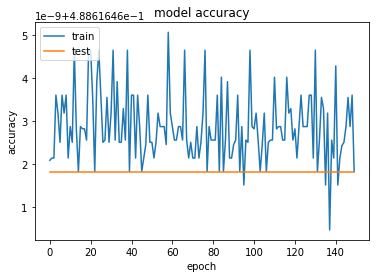

In [67]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(lstmhistory.history['acc'])
plt.plot(lstmhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
print('Build model...')
batch_size = 32
maxlen = 80

x_train_short = pad_sequences(x_train, maxlen=maxlen)
x_test_short = pad_sequences(x_train, maxlen=maxlen)

model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, 128))
model_lstm.add(LSTM(128, dropout=0.15, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='tanh'))

# try using different optimizers and different optimizer configs
model_lstm.compile(loss='binary_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

print('Train...')
lstmhistory1 = model_lstm.fit(x_train_short, y_train, batch_size=batch_size, epochs=65,
          validation_data=(x_test_short, y_test))

Build model...
Train...
Train on 571 samples, validate on 571 samples
Epoch 1/65
571/571 [==============================] - ETA: 25s - loss: -2.0728 - acc: 0.500 - ETA: 12s - loss: -1.1859 - acc: 0.531 - ETA: 8s - loss: -0.7924 - acc: 0.510 - ETA: 6s - loss: -0.4541 - acc: 0.47 - ETA: 5s - loss: -0.3455 - acc: 0.46 - ETA: 4s - loss: -0.2665 - acc: 0.47 - ETA: 3s - loss: -0.2433 - acc: 0.48 - ETA: 2s - loss: -0.1452 - acc: 0.48 - ETA: 2s - loss: -0.1186 - acc: 0.48 - ETA: 2s - loss: -0.1268 - acc: 0.48 - ETA: 1s - loss: -0.0759 - acc: 0.47 - ETA: 1s - loss: 0.0977 - acc: 0.4740 - ETA: 1s - loss: -0.0346 - acc: 0.47 - ETA: 0s - loss: -0.0981 - acc: 0.47 - ETA: 0s - loss: -0.1170 - acc: 0.47 - ETA: 0s - loss: -0.1011 - acc: 0.48 - ETA: 0s - loss: -0.1026 - acc: 0.49 - 4s - loss: -0.0733 - acc: 0.4886 - val_loss: 0.1519 - val_acc: 0.4886
Epoch 2/65
571/571 [==============================] - ETA: 2s - loss: -0.1829 - acc: 0.50 - ETA: 1s - loss: -0.9237 - acc: 0.51 - ETA: 1s - loss: -1.0923 

571/571 [==============================] - ETA: 1s - loss: -3.5258 - acc: 0.65 - ETA: 1s - loss: -4.2478 - acc: 0.65 - ETA: 1s - loss: -4.0023 - acc: 0.68 - ETA: 1s - loss: -4.0090 - acc: 0.65 - ETA: 1s - loss: -4.5166 - acc: 0.66 - ETA: 1s - loss: -4.4354 - acc: 0.65 - ETA: 1s - loss: -4.2264 - acc: 0.64 - ETA: 1s - loss: -4.2623 - acc: 0.64 - ETA: 1s - loss: -4.0684 - acc: 0.63 - ETA: 0s - loss: -4.2117 - acc: 0.62 - ETA: 0s - loss: -4.0083 - acc: 0.61 - ETA: 0s - loss: -3.8830 - acc: 0.61 - ETA: 0s - loss: -3.8555 - acc: 0.62 - ETA: 0s - loss: -3.7913 - acc: 0.62 - ETA: 0s - loss: -3.7703 - acc: 0.62 - ETA: 0s - loss: -3.6921 - acc: 0.62 - ETA: 0s - loss: -3.6787 - acc: 0.62 - 2s - loss: -3.7023 - acc: 0.6287 - val_loss: 3.2639 - val_acc: 0.3643
Epoch 22/65
571/571 [==============================] - ETA: 1s - loss: -3.0221 - acc: 0.59 - ETA: 1s - loss: -3.7770 - acc: 0.67 - ETA: 1s - loss: -4.0288 - acc: 0.71 - ETA: 1s - loss: -3.6440 - acc: 0.66 - ETA: 1s - loss: -3.6202 - acc: 0.6

571/571 [==============================] - ETA: 1s - loss: -2.5184 - acc: 0.53 - ETA: 1s - loss: -3.5036 - acc: 0.65 - ETA: 1s - loss: -3.1752 - acc: 0.67 - ETA: 1s - loss: -3.3732 - acc: 0.69 - ETA: 1s - loss: -3.4036 - acc: 0.68 - ETA: 1s - loss: -3.4183 - acc: 0.67 - ETA: 1s - loss: -3.5766 - acc: 0.66 - ETA: 1s - loss: -3.6331 - acc: 0.67 - ETA: 1s - loss: -3.8451 - acc: 0.66 - ETA: 0s - loss: -3.7627 - acc: 0.67 - ETA: 0s - loss: -3.9243 - acc: 0.65 - ETA: 0s - loss: -3.8460 - acc: 0.66 - ETA: 0s - loss: -3.8213 - acc: 0.65 - ETA: 0s - loss: -3.7264 - acc: 0.64 - ETA: 0s - loss: -3.6735 - acc: 0.64 - ETA: 0s - loss: -3.6626 - acc: 0.63 - ETA: 0s - loss: -3.7138 - acc: 0.62 - 2s - loss: -3.6511 - acc: 0.6200 - val_loss: 3.2457 - val_acc: 0.3485
Epoch 42/65
571/571 [==============================] - ETA: 1s - loss: -2.4972 - acc: 0.71 - ETA: 1s - loss: -3.2632 - acc: 0.60 - ETA: 1s - loss: -3.6768 - acc: 0.58 - ETA: 1s - loss: -3.6145 - acc: 0.63 - ETA: 1s - loss: -3.6879 - acc: 0.6

571/571 [==============================] - ETA: 1s - loss: -5.0250 - acc: 0.53 - ETA: 1s - loss: -4.2754 - acc: 0.54 - ETA: 1s - loss: -4.1934 - acc: 0.61 - ETA: 1s - loss: -4.1377 - acc: 0.61 - ETA: 1s - loss: -4.2961 - acc: 0.61 - ETA: 1s - loss: -3.9159 - acc: 0.62 - ETA: 1s - loss: -3.6441 - acc: 0.61 - ETA: 1s - loss: -3.7526 - acc: 0.63 - ETA: 1s - loss: -3.8393 - acc: 0.62 - ETA: 0s - loss: -3.6637 - acc: 0.63 - ETA: 0s - loss: -3.6053 - acc: 0.63 - ETA: 0s - loss: -3.5531 - acc: 0.62 - ETA: 0s - loss: -3.7032 - acc: 0.61 - ETA: 0s - loss: -3.7592 - acc: 0.61 - ETA: 0s - loss: -3.7101 - acc: 0.61 - ETA: 0s - loss: -3.6965 - acc: 0.61 - ETA: 0s - loss: -3.6569 - acc: 0.61 - 2s - loss: -3.6251 - acc: 0.6112 - val_loss: 3.0925 - val_acc: 0.3398
Epoch 62/65
571/571 [==============================] - ETA: 1s - loss: -1.9912 - acc: 0.62 - ETA: 1s - loss: -1.2335 - acc: 0.54 - ETA: 1s - loss: -1.8297 - acc: 0.54 - ETA: 1s - loss: -2.1173 - acc: 0.54 - ETA: 1s - loss: -2.2909 - acc: 0.5

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


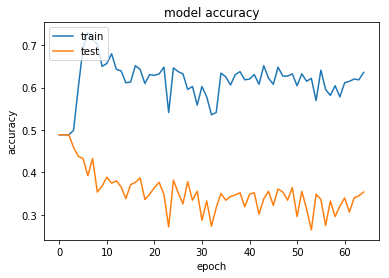

In [102]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(lstmhistory1.history['acc'])
plt.plot(lstmhistory1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Building the CNN model

In [86]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='linear')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='linear')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='linear')(x)
x = MaxPooling1D(7)(x)  # modified from example since our seq len is 300 
x = Flatten()(x)
x = Dense(128, activation='linear')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          819600    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 296, 128)          192128    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 59, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 55, 128)           82048     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 11, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 7, 128)            82048     
__________

In [88]:
print('Training model.')
cnnhistory = model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=200, batch_size=128)

Training model.
Train on 571 samples, validate on 571 samples
Epoch 1/200
571/571 [==============================] - ETA: 2s - loss: 0.7030 - acc: 0.296 - ETA: 0s - loss: 0.6625 - acc: 0.398 - ETA: 0s - loss: 0.6293 - acc: 0.421 - ETA: 0s - loss: 0.5965 - acc: 0.455 - 1s - loss: 0.5539 - acc: 0.4553 - val_loss: 0.1999 - val_acc: 0.4886
Epoch 2/200
571/571 [==============================] - ETA: 0s - loss: 0.1449 - acc: 0.539 - ETA: 0s - loss: 0.1359 - acc: 0.507 - ETA: 0s - loss: -0.0176 - acc: 0.48 - ETA: 0s - loss: 0.1223 - acc: 0.4824 - 0s - loss: 0.1540 - acc: 0.4886 - val_loss: 0.0531 - val_acc: 0.4886
Epoch 3/200
571/571 [==============================] - ETA: 0s - loss: 0.0013 - acc: 0.406 - ETA: 0s - loss: 0.0810 - acc: 0.457 - ETA: 0s - loss: -0.0199 - acc: 0.48 - ETA: 0s - loss: -0.1881 - acc: 0.50 - 0s - loss: -0.1628 - acc: 0.4886 - val_loss: -0.1052 - val_acc: 0.4886
Epoch 4/200
571/571 [==============================] - ETA: 0s - loss: -0.1486 - acc: 0.45 - ETA: 0s - loss

571/571 [==============================] - ETA: 0s - loss: -3.7640 - acc: 0.74 - ETA: 0s - loss: -3.9496 - acc: 0.73 - ETA: 0s - loss: -3.7602 - acc: 0.75 - ETA: 0s - loss: -3.7836 - acc: 0.74 - 0s - loss: -3.7568 - acc: 0.7478 - val_loss: -1.4090 - val_acc: 0.5289
Epoch 60/200
571/571 [==============================] - ETA: 0s - loss: -2.8731 - acc: 0.81 - ETA: 0s - loss: -3.1910 - acc: 0.78 - ETA: 0s - loss: -3.5060 - acc: 0.76 - ETA: 0s - loss: -3.7232 - acc: 0.75 - 0s - loss: -3.7581 - acc: 0.7513 - val_loss: -1.3172 - val_acc: 0.5324
Epoch 61/200
571/571 [==============================] - ETA: 0s - loss: -3.3848 - acc: 0.76 - ETA: 0s - loss: -3.5127 - acc: 0.76 - ETA: 0s - loss: -3.7175 - acc: 0.75 - ETA: 0s - loss: -3.8536 - acc: 0.74 - 0s - loss: -3.7521 - acc: 0.7496 - val_loss: -1.2373 - val_acc: 0.5377
Epoch 62/200
571/571 [==============================] - ETA: 0s - loss: -3.2547 - acc: 0.78 - ETA: 0s - loss: -3.9514 - acc: 0.74 - ETA: 0s - loss: -3.7160 - acc: 0.75 - ETA: 0

571/571 [==============================] - ETA: 0s - loss: -4.6514 - acc: 0.71 - ETA: 0s - loss: -4.1961 - acc: 0.72 - ETA: 0s - loss: -4.0533 - acc: 0.73 - ETA: 0s - loss: -3.7882 - acc: 0.74 - 0s - loss: -3.7614 - acc: 0.7478 - val_loss: -1.2822 - val_acc: 0.5236
Epoch 118/200
571/571 [==============================] - ETA: 0s - loss: -3.2511 - acc: 0.78 - ETA: 0s - loss: -3.6265 - acc: 0.76 - ETA: 0s - loss: -3.8365 - acc: 0.75 - ETA: 0s - loss: -3.7248 - acc: 0.75 - 0s - loss: -3.7633 - acc: 0.7531 - val_loss: -1.2142 - val_acc: 0.5289
Epoch 119/200
571/571 [==============================] - ETA: 0s - loss: -4.0218 - acc: 0.73 - ETA: 0s - loss: -3.6821 - acc: 0.74 - ETA: 0s - loss: -3.7120 - acc: 0.75 - ETA: 0s - loss: -3.8499 - acc: 0.74 - 0s - loss: -3.7602 - acc: 0.7496 - val_loss: -1.2959 - val_acc: 0.5271
Epoch 120/200
571/571 [==============================] - ETA: 0s - loss: -3.8723 - acc: 0.73 - ETA: 0s - loss: -4.0094 - acc: 0.73 - ETA: 0s - loss: -3.6269 - acc: 0.75 - ETA

571/571 [==============================] - ETA: 0s - loss: -3.6206 - acc: 0.75 - ETA: 0s - loss: -3.7498 - acc: 0.74 - ETA: 0s - loss: -3.8415 - acc: 0.74 - ETA: 0s - loss: -3.6948 - acc: 0.75 - 0s - loss: -3.7626 - acc: 0.7478 - val_loss: -1.2972 - val_acc: 0.5412
Epoch 176/200
571/571 [==============================] - ETA: 0s - loss: -4.0073 - acc: 0.73 - ETA: 0s - loss: -3.9505 - acc: 0.73 - ETA: 0s - loss: -3.7545 - acc: 0.74 - ETA: 0s - loss: -3.6629 - acc: 0.75 - 0s - loss: -3.7627 - acc: 0.7461 - val_loss: -1.2298 - val_acc: 0.5412
Epoch 177/200
571/571 [==============================] - ETA: 0s - loss: -3.6359 - acc: 0.76 - ETA: 0s - loss: -3.8309 - acc: 0.75 - ETA: 0s - loss: -3.7586 - acc: 0.74 - ETA: 0s - loss: -3.6664 - acc: 0.75 - 0s - loss: -3.7624 - acc: 0.7461 - val_loss: -1.2415 - val_acc: 0.5377
Epoch 178/200
571/571 [==============================] - ETA: 0s - loss: -2.8739 - acc: 0.79 - ETA: 0s - loss: -3.4358 - acc: 0.75 - ETA: 0s - loss: -3.7137 - acc: 0.74 - ETA

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


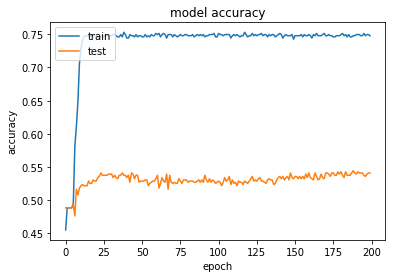

In [89]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Calculating the cosine value

In [54]:
zz = np.array(abc).reshape(1,-1)

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(vvv,
                  zz)

array([[ 0.4545526]])